In [134]:
import pandas as pd
import numpy as np
import sys, re, requests, collections, glob, time 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import os
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix
import json
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [171]:
#Testing and Training on Regular Season Results Only

regSeason = pd.read_csv("RegularSeasonResults.csv", header = 0,index_col = 0)
print(regSeason.head())
X = regSeason.drop(["target", "deltaWins"], axis = 1)
y = regSeason[["target"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 50)

                target  deltaOR  deltaStl  deltaFTP  deltaAst  deltaNeutWin  \
2003_1102_1117       1    -6.78     -1.19     -8.65      1.08          -1.0   
2003_1102_1125       1    -6.36     -3.11     -5.05     -3.89          -2.0   
2003_1102_1140       0    -6.69     -0.98    -10.16     -0.42          -4.0   
2003_1102_1161       1    -6.62      0.63     -4.91     -2.50          -2.0   
2003_1102_1204       1    -9.32     -1.42      0.99     -0.62          -1.0   

                deltaPF  deltaAwayWin  deltaFGP  deltaWinRank  deltaBlk  \
2003_1102_1117    -2.67           0.0      4.79         -4.70      0.14   
2003_1102_1125     0.39          -4.0      1.53        -11.88      0.08   
2003_1102_1140    -2.67          -3.0      1.23         95.75     -0.73   
2003_1102_1161    -1.82           0.0     -2.56         62.10     -2.44   
2003_1102_1204    -0.67          -3.0      2.22        -21.94     -1.90   

                deltaFG3  deltaWins  deltaLossRank  deltaDR  deltaGames  \

In [179]:
#Testing Parameters  
xgb = XGBClassifier(
    objective='binary:logistic',
    silent=True,
    nthread=1,
    seed = 27)

params = {
        'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3], #eta: Step size shrinkage used in update to prevents overfitting.
        'min_child_weight': [1, 5, 10], # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
        'gamma': [0, 0.5, 1, 1.5, 2, 5], #min_split_loss: Minimum loss reduction required to make a further partition on a leaf node of the tree.
        'subsample': [0.6, 0.7, 0.8, 0.9], #Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. 
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0], #subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
        'max_depth': [3, 4, 5, 6, 7], #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
        'n_estimators' : [50,100,150,200,250,300] # Number of trees used
        }

folds = 5
param_comb = 50
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='neg_log_loss',
                                   n_jobs=2,
                                   cv=skf.split(X_train,y_train),
                                   verbose=3,
                                   random_state=1001)

random_search.fit(X_train, y_train.values.ravel())


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed: 16.0min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f9b05384990>,
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=2,
          param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], 'min_child_weight': [1, 5, 10], 'gamma': [0, 0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.4, 0.6, 0.8, 1.0], 'max_depth': [3, 4, 5, 6, 7], 'n_estimators': [50, 100, 150, 200, 250, 300]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring='neg_log

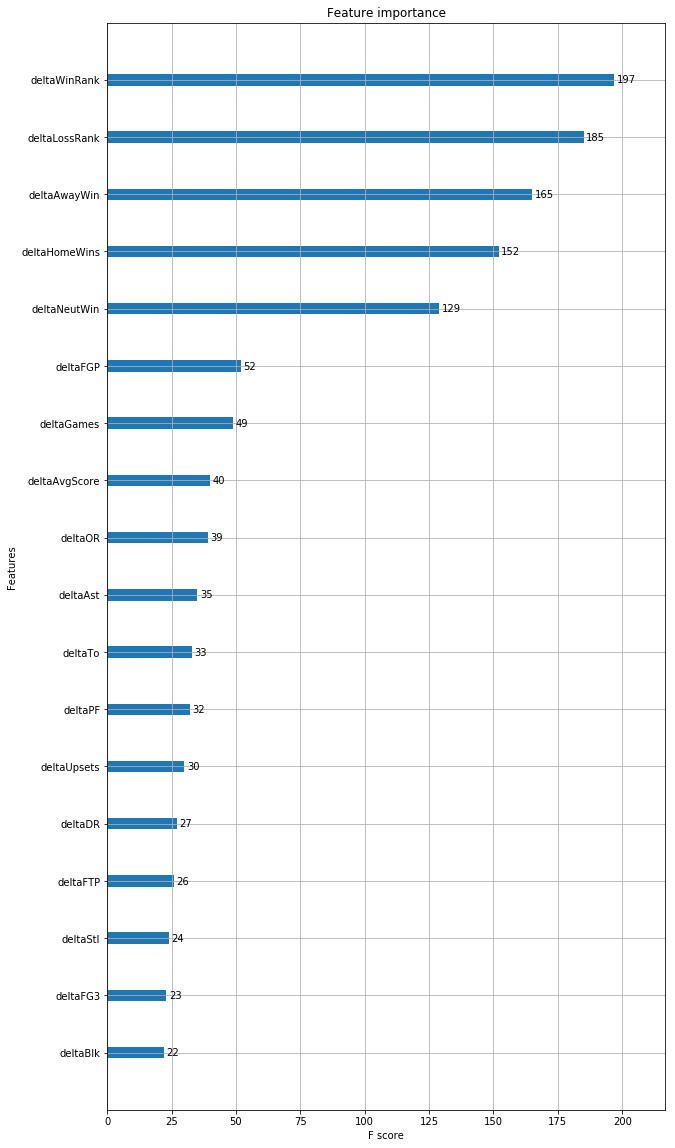


 Best score for 5-fold search with 50 parameter combinations:
-0.4601663236990827

 Best hyperparameters:
{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 0.6}


In [174]:
my_plot_importance(random_search.best_estimator_, (10,20))
plt.show()

print('\n Best score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_)
print('\n Best hyperparameters:')
print(random_search.best_params_)
#results = pd.DataFrame(random_search.cv_results_)

In [175]:
#Results of our Randomized Grid Search
preds = random_search.predict_proba(X_test)

predictions = [round(value) for value in preds[:,1]]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Log Loss: {}".format(log_loss(y_test, preds)))


#results_df.to_csv('submission-random-grid-search-xgb-porto-01.csv', index=False)

Accuracy: 77.45%
Log Loss: 0.4517522417959046


In [ ]:
# grid search
model = XGBClassifier()
n_estimators = [50, 100, 150, 200, 250]
max_depth = [2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y.values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')


[2, 4, 6, 8]
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min


In [83]:
teamNames = pd.read_csv("data/Teams.csv", header = 0)
teamNameMap = dict(zip(teamNames["TeamName"].str.lower(), teamNames["TeamID"])) 

altTeamNames = pd.read_csv("data/TeamSpellings.csv", header = 0, encoding = 'latin-1')
altTeamNameMap = dict(zip(altTeamNames['TeamNameSpelling'].str.lower(), teamNames["TeamID"]))

finalTeamNameMap = {**teamNameMap, **altTeamNameMap}



In [177]:
seasonAverages = pd.read_csv("data/SeasonAverages.csv", header = 0, index_col = 0)

def compareMatchups(season_team1_team2, regSeasonDf):
    season, team1, team2 = season_team1_team2.split("_")
    team1_idx = str(season) + "_" + str(team1)
    team2_idx = str(season) + "_" + str(team2)
    team1_dict = regSeasonDf.loc[team1_idx].to_dict()
    team2_dict = regSeasonDf.loc[team2_idx].to_dict()
    
    deltaOR = team1_dict['avgOR'] - team2_dict['avgOR']
    deltaStl = team1_dict['avgStl'] - team2_dict['avgStl']
    deltaFTP = team1_dict['Avg FT%'] - team2_dict['Avg FT%']
    deltaAst = team1_dict['avgAst'] - team2_dict['avgAst']
    deltaNeutWin = team1_dict['Neutral Win'] - team2_dict['Neutral Win']
    deltaPF = team1_dict['avgPf'] - team2_dict["avgPf"]
    deltaAwayWin = team1_dict['Away Win'] - team2_dict['Away Win']
    deltaFGP = team1_dict['Avg FG%'] - team2_dict["Avg FG%"]
    deltaWinRank = team1_dict["AvgWinRank"] - team2_dict['AvgWinRank']
    deltaBlk = team1_dict['avgBlk'] - team2_dict['avgBlk']
    deltaFG3 = team1_dict['Avg FG3%'] - team2_dict["Avg FG3%"]
    deltaWins = team1_dict['Wins'] - team2_dict['Losses']
    deltaLossRank = team1_dict["AvgLossRank"] - team2_dict["AvgLossRank"]
    deltaDR = team1_dict['avgDr'] - team2_dict['avgDr']
    deltaGames = team1_dict['Games'] - team2_dict['Games']
    deltaAvgScore = team1_dict['avgScore'] - team2_dict["avgScore"]
    deltaUpsets = team1_dict["Upsets"] - team2_dict["Upsets"]
    deltaHomeWins = team1_dict["Home Win"] - team2_dict["Home Win"]
    deltaTo = team1_dict["AvgTO"] - team2_dict["AvgTO"]
    
    out_dict = {
        'deltaOR' : round(deltaOR,2),
        'deltaStl' : round(deltaStl,2),
        'deltaFTP' : round(deltaFTP,2),
        'deltaAst' : round(deltaAst,2),
        'deltaNeutWin' : round(deltaNeutWin,2),
        'deltaPF' : round(deltaPF,2),
        'deltaAwayWin' : round(deltaAwayWin,2),
        'deltaFGP' : round(deltaFGP,2),
        'deltaWinRank' : round(deltaWinRank,2),
        'deltaBlk' : round(deltaBlk,2),
        'deltaFG3' : round(deltaFG3,2),
        #'deltaWins' : round(deltaWins,2),
        'deltaLossRank' : round(deltaLossRank,2),
        'deltaDR' : round(deltaDR,2),
        'deltaGames' : round(deltaGames,2),
        'deltaAvgScore' : round(deltaAvgScore,2),
        'deltaUpsets' : round(deltaUpsets,2),
        'deltaHomeWins' : round(deltaHomeWins,2),
        'deltaTo' : round(deltaTo,2)
    }
    return out_dict

submissionDf = pd.read_csv("SampleSubmissionStage1.csv", header = 0)

mapping_dict = {}
for idx, row in submissionDf.iterrows():
    comparison = row["ID"]
    mapping_dict[comparison] = compareMatchups(comparison, seasonAverages)


def checkMatchupByName(season, team1, team2, teamNameMap, seasonAverages, model):
    team1_id = teamNameMap[team1.lower()]
    team2_id = teamNameMap[team2.lower()]
    print(team1_id, team2_id)
    search_term = str(season) + "_" + str(team1_id) + "_" + str(team2_id)
    
    outResultDict = {search_term: compareMatchups(search_term, seasonAverages)}
    #testMatrix = xgb.DMatrix(pd.DataFrame.from_dict(outResultDict, orient = 'index').values)
    #pred = model.predict(testMatrix)
    testDf = pd.DataFrame.from_dict(outResultDict, orient = 'index')
    pred = model.predict_proba(testDf)[:,1] # pred[:,0] is the reverse probability
    print("{} has a {}% chance to beat {}".format(team1, round(pred[0] * 100,2), team2))


checkMatchupByName(2016, "Villanova", "North Carolina", finalTeamNameMap, seasonAverages, random_search)
    

1437 1314
Villanova has a 50.69% chance to beat North Carolina


In [178]:
comparisonDf = pd.DataFrame.from_dict(mapping_dict, orient = 'index')
submitPreds = random_search.predict_proba(comparisonDf)[:,1]


predDict = dict(zip(comparisonDf.index, submitPreds))

with open('SubmissionStage1.csv', 'w') as f:
    f.write("ID,Pred\n")
    for k,v in predDict.items():
        f.write(str(k) + "," + str(v) + "\n")
